In [1]:
import pandas as pd
import re
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

df_ids = pd.read_csv(f"../data/cache2/processed/smiles.tsv", sep='\t')
df_boltz = pd.read_csv(f"../results_summary/hparams.tsv", sep='\t')
df_boltz.columns = ['sample', 'id', 'affinity_probability_binary']
df = df_ids.merge(df_boltz, on='id')


In [2]:
def extract_param(sample_str, prefix1, prefix2):
    try:
        match1 = re.search(f"{prefix1}(\\d+)", sample_str)
        match2 = re.search(f"{prefix2}(\\d+)", sample_str)
        return f"{prefix1}{match1.group(1)}_{prefix2}{match2.group(1)}" if match1 and match2 else None
    except:
        return None

df['pr_ar'] = df['sample'].apply(lambda x: extract_param(x, 'pr', 'ar'))
df['ps_as'] = df['sample'].apply(lambda x: extract_param(x, 'ps', 'as'))
df['pd_ad'] = df['sample'].apply(lambda x: extract_param(x, 'pd', 'ad'))
df['experiment'] = df.apply(lambda x: x['sample'][-2:], axis=1)


In [3]:
def bootstrap_roc_ci(y_true, y_score, n_bootstraps=1000, seed=42):
    rng = np.random.RandomState(seed)
    bootstrapped_scores = []

    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_score), len(y_score))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_score[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    lower = sorted_scores[int(0.025 * len(sorted_scores))]
    upper = sorted_scores[int(0.975 * len(sorted_scores))]

    return lower, upper

def plot_roc_with_ci(df, group_col, title='', max_groups=10):
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    added = 0

    plt.figure(figsize=(10, 8))

    for i, group_name in enumerate(sorted(df[group_col].unique())):
        if added >= max_groups:
            break

        group_df = df[df[group_col] == group_name]
        if group_df['binder'].nunique() < 2:
            continue

        try:
            y_true = group_df['binder'].astype(int).values
            y_score = group_df['affinity_probability_binary'].values

            fpr, tpr, _ = roc_curve(y_true, y_score)
            auc_score = roc_auc_score(y_true, y_score)
            ci_lower, ci_upper = bootstrap_roc_ci(y_true, y_score)

            color = color_cycle[added % len(color_cycle)]
            plt.plot(fpr, tpr, label=f"{group_name} (AUC={auc_score:.2f}, 95% CI [{ci_lower:.2f}, {ci_upper:.2f}])", color=color)

            added += 1

        except Exception as e:
            print(f"Ошибка в группе {group_name}: {e}")

    plt.plot([0, 1], [0, 1], 'k--', label='Random baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title or f'ROC curves with CI per {group_col}')
    plt.legend(loc='lower right', fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


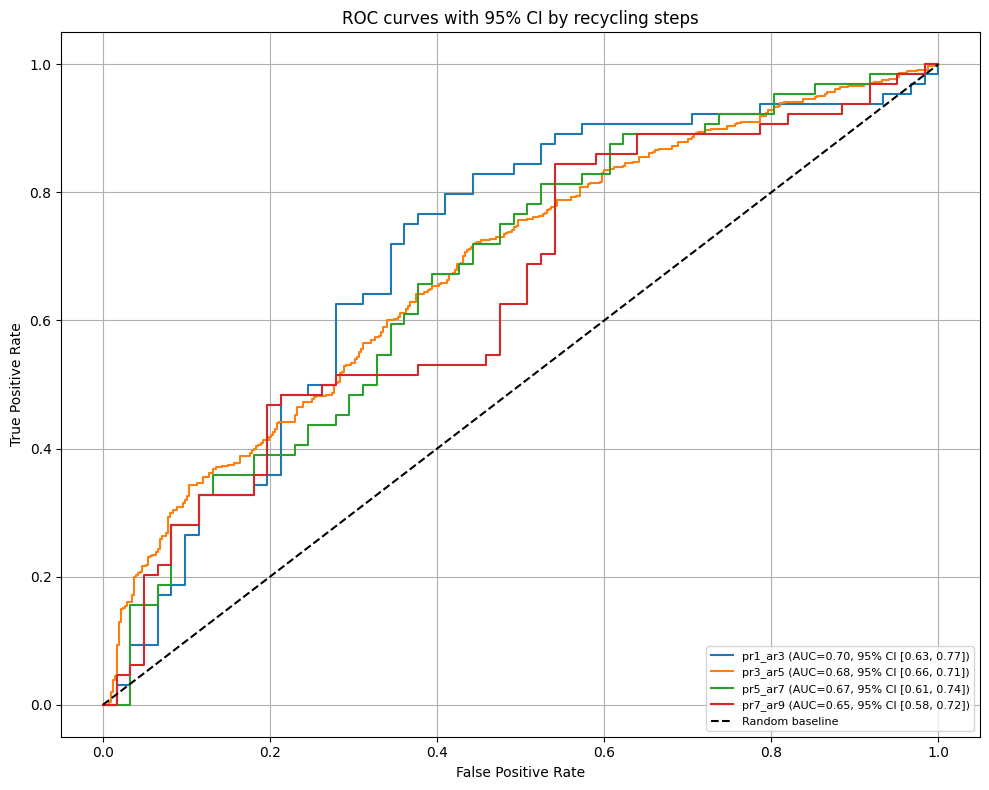

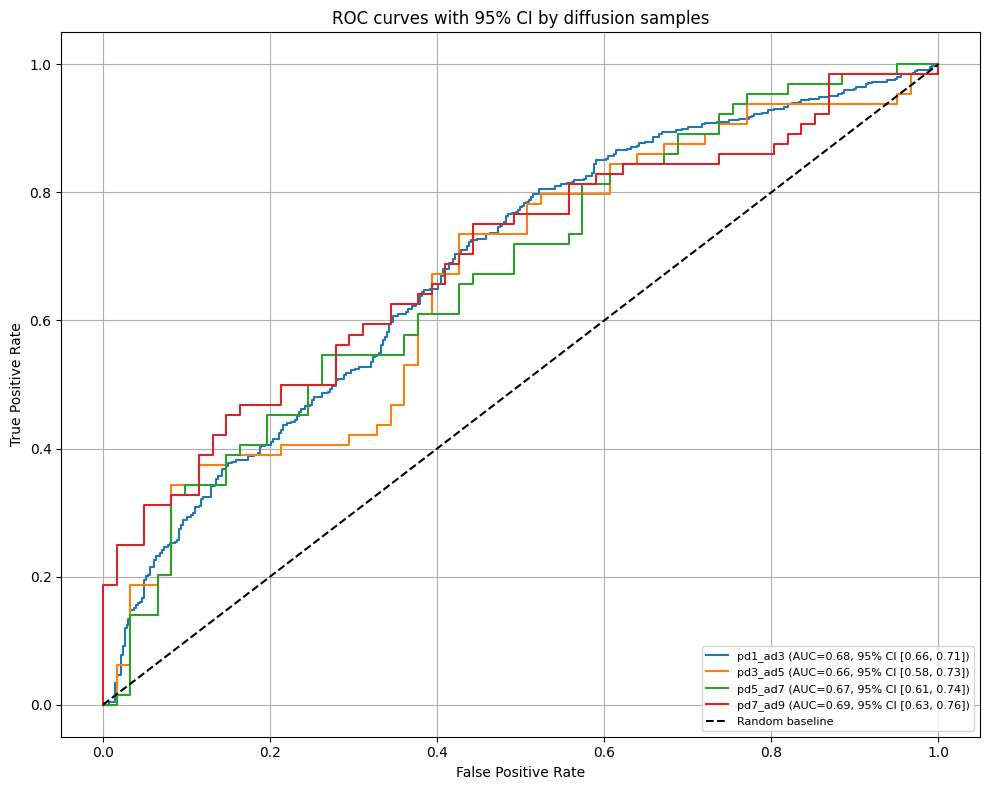

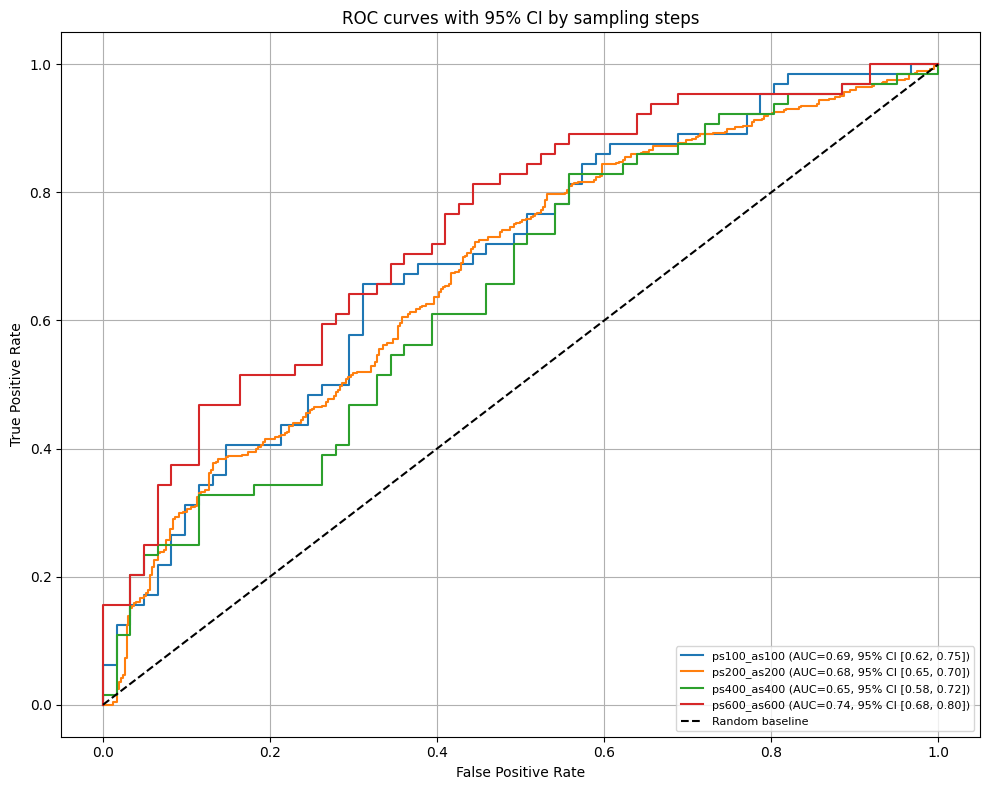

In [4]:
plot_roc_with_ci(
    df=df,
    group_col='pr_ar',
    title='ROC curves with 95% CI by recycling steps',
    max_groups=6
)

plot_roc_with_ci(
    df=df,
    group_col='pd_ad',
    title='ROC curves with 95% CI by diffusion samples',
    max_groups=6
)

plot_roc_with_ci(
    df=df,
    group_col='ps_as',
    title='ROC curves with 95% CI by sampling steps',
    max_groups=6
)
